## Pix2Pix Implementation

In this notebook we are going to implement Pix2Pix GAN for Image-to-Image Translation.

Its going to be a bit trickier than the other types GAN.

Even though Pix2Pix does take inspiration from Conditional GAN, it states some issue which were already present in the research field. 

**_Disclaimer : I tend to import all the necessary packages in the first cell only, so don't get scared as such, everything is explained in the subsequent sections!_**

In [1]:
## Importing the necessary packages ##

import torch
import torch.nn as nn
from torch.utils.data import Dataset , DataLoader
from torchvision.utils import make_grid , save_image
from torchvision.transforms import transforms
from torchvision.transforms.functional import resize 
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt

import os

Now we are going to implement Pix2Pix in the cityscapes dataset, which was one of the dataset that the original authors did their experiments on. 

Preferrably its better to load the dataset first and move on from that, since, it would clearly show the objective of our project.

So, in the next cell we are going to implement our custom cityscapes dataset.

Now this dataset is unique. Here, both the input and the target image are merged into one image of width 512 and height 256.

So, we need to split the image out to get the target and input images separately.

In [2]:
## Constructing the dataset ##

class cityDataset(Dataset):
    def __init__(self , root_path):
        self.root = root_path
        self.img_lst = os.listdir(root_path)
        self.length = len(self.img_lst)
        
    def __getitem__(self , index):
        cyclic_idx = index % self.length
        merged_img_path = os.path.join(self.root , self.img_lst[cyclic_idx])
        merged_img = np.array(Image.open(merged_img_path).convert('RGB'))
        
        inp_img = merged_img[: , : 256 , :] 
        target_img = merged_img[: , 256 : , :] 
        
        aug = transforms.Compose([transforms.ToTensor(),
                                  transforms.Normalize((0.5 , ) , (0.5 , ))
                                 ])
        
        inp_img = aug(inp_img)
        target_img = aug(target_img)
        
        return inp_img , target_img
    
    def __len__(self):
        return self.length

We are going to visualize in later parts and a denormalize function needs to be there.

In [3]:
## Denormalization function ##

def denormalize(img):
    return img * 0.5 + 0.5

With that out of the way lets also instantiate the Dataset object.

Length of the dataset is : 2975
The maximum value of input and target image are : tensor(1.) tensor(1.)
The minimum value of input and target image are : tensor(-1.) tensor(-1.)


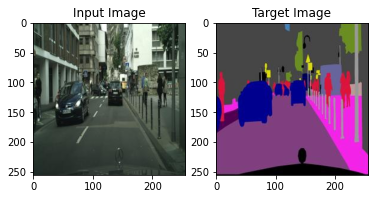

In [4]:
## Instantiating the dataset object ##

city_data = cityDataset('D://DL_Using_Pytorch//GAN//5.Pix2Pix//cityscapes//cityscapes//train')

## Checking length of the data ##

print('Length of the dataset is :' , len(city_data))


## Displaying an example image ##

# Getting a random index #

random_idx = int(np.random.randint(low = 0 , high = len(city_data) , size = 1))

inp_img , target_img = city_data[random_idx]

print('The maximum value of input and target image are :', torch.max(inp_img) , torch.max(target_img))
print('The minimum value of input and target image are :', torch.min(inp_img) , torch.min(target_img))

plt.subplot(1 , 2 , 1)
plt.imshow(denormalize(inp_img).permute(1 , 2 , 0))
plt.title('Input Image')

plt.subplot(1 , 2 , 2)
plt.imshow(denormalize(target_img).permute(1 , 2 , 0))
plt.title('Target Image')

plt.show()

Now, with that, lets set up the Dataloader which feeds in the data batch by batch.

In [5]:
## Setting up the dataloader ##

city_dataloader = DataLoader(city_data , batch_size = 16 , shuffle = True)

print('Dataloader length :' , len(city_dataloader))

Dataloader length : 186


Its always better to visualize data.

Hence, it would be awesome to visualize a batch of data of the dataloader.

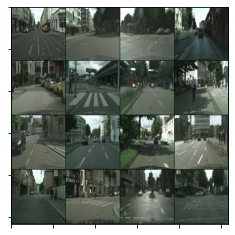

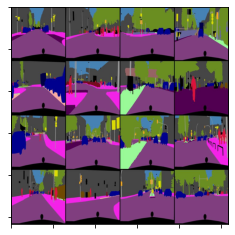

In [6]:
## Visualizing a batch of data of dataloader ##

for inp, target in city_dataloader:
    fig , ax = plt.subplots(figsize = (4 , 4))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    plt.imshow(make_grid(denormalize(inp) , 4).permute(1 , 2 , 0))
    
    fig , ax = plt.subplots(figsize = (4 , 4))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    plt.imshow(make_grid(denormalize(target) , 4).permute(1 , 2 , 0))
    
    break

Its visible, hence, our dataloader is working okay.

Now what I love to do is shift our dataloader to the Graphics card.

In the next cells we are going to write some function to do exactly that.

So, lets do that!!

In [7]:
## Checking for the device ##

def check_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    return torch.device('cpu')

## Transfering data to device ##

def transfer_data(data , device):
    if isinstance(data , (tuple , list)):
        return [transfer_data(each_data , device) for each_data in data]
    return data.to(device)

## GPU Dataloader ##

class GPUDataLoader():
    def __init__(self , data , device):
        self.data = data
        self.device = device
        
    def __iter__(self):
        for data_batch in self.data:
            yield transfer_data(data_batch , self.device)
    
    def __len__(self):
        return len(self.data)

Now lets instantiate the device and the dataloader. Also, visualize some data.

In [8]:
## Getting the device ##

device = check_device()

## Instantiating the dataloader ##

city_dl = GPUDataLoader(city_dataloader , device)

print('Length of the Dataloader is :' , len(city_dl))

Length of the Dataloader is : 186


torch.Size([256, 256])


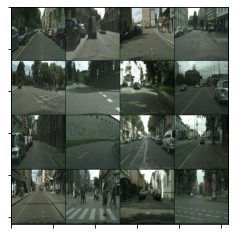

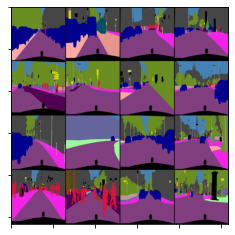

In [9]:
## Visualizing a batch of data of dataloader ##

for inp, target in city_dl:
    print(inp[0][0].shape)
    fig , ax = plt.subplots(figsize = (4 , 4))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    plt.imshow(make_grid(denormalize(inp.to('cpu')) , 4).permute(1 , 2 , 0))
    
    fig , ax = plt.subplots(figsize = (4 , 4))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    plt.imshow(make_grid(denormalize(target.to('cpu')) , 4).permute(1 , 2 , 0))
    
    break

Yes!! Everything is working fine!!

Now, its time for the final stride of our project.

Its time for model creation.

We are going to build our Generator and Discriminator models now.

In [10]:
## Defining Generator model ##

class ConvBlock(nn.Module):
    def __init__(self , in_channels , out_channels , kernel_size = 4, padding = 1 , 
                 stride = 2, dropout = False , batch_norm = True , activation = "leakyrelu" , path = "encoder"):
        
        super().__init__()
        self.dropout = dropout
        self.batch_norm = batch_norm
        self.activation = activation
        self.path = path
        
        self.conv = nn.Conv2d(in_channels = in_channels , out_channels = out_channels , kernel_size = kernel_size ,
                              padding = padding , stride = stride)
        
        self.conv_trans = nn.ConvTranspose2d(in_channels = in_channels , out_channels = out_channels , 
                                             kernel_size = kernel_size , padding = padding , stride = stride)
        
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.drop = nn.Dropout(0.5)
        self.leaky = nn.LeakyReLU(0.2)
        
    def forward(self , x):
        
        if self.path == "encoder":
            x = self.conv(x)
            
        if self.path == "decoder":
            x = self.conv_trans(x)
        
        if self.batch_norm:
            x = self.bn(x)
        
        if self.dropout:
            x = self.drop(x)
        
        if self.activation == "relu":
            x = self.relu(x)
            
        if self.activation == "leakyrelu":
            x = self.leaky(x)
            
        return x
    

class Generator(nn.Module):
    
    def __init__(self , in_channels = 3 , out_channels = 3 , filters = [64 , 128 , 256 , 512 , 512 , 512 , 512]):
        super().__init__()
        self.out_channels = out_channels
        self.filters = filters
        
        self.encoder = nn.ModuleList([])
        self.decoder = nn.ModuleList([])
        
        self.encoder.append(ConvBlock(in_channels = in_channels , out_channels = self.filters[0] , batch_norm = False)) #64, 128
        in_channels = self.filters[0]
        for each_filter in self.filters[1:]: #128, 64 , #256,32 , #512,16 , #512,8 , #512,4 , #512 , 2
            self.encoder.append(ConvBlock(in_channels = in_channels , out_channels = each_filter))
            in_channels = each_filter
        
        self.bridge = ConvBlock(in_channels = self.filters[-1] , out_channels = self.filters[-1] , batch_norm = False,
                                activation = "relu") #512 ,1
        
        
        
        for idx , each_filter in enumerate(reversed(self.filters[:-1])):
            #512,2 #1024,2 #1024,8 #1024,16
            if idx == 0:
                self.decoder.append(ConvBlock(in_channels = each_filter , out_channels = self.filters[len(self.filters)-( 2 + idx)] , dropout = True,
                                              activation = "relu" , path = "decoder"))
            if idx == 1 or idx == 2:
                self.decoder.append(ConvBlock(in_channels = each_filter * 2 , out_channels = each_filter , dropout = True,
                                              activation = "relu" , path = "decoder"))
            else:
                self.decoder.append(ConvBlock(in_channels = self.filters[len(self.filters) - (1 + idx)] * 2 , out_channels = each_filter,
                                              activation = "relu" , path = "decoder"))
                
        self.final_layer = nn.Sequential(nn.ConvTranspose2d(in_channels = self.filters[0] * 2 , out_channels = self.out_channels,
                                     kernel_size = 4 , padding = 1 , stride  = 2),
                                     nn.Tanh())
                
    def forward(self , x):
        
        down_features = []
        
        for layer in self.encoder:
            
            x = layer(x)
            down_features.append(x)
        
        x = self.bridge(x)
        
        down_features = down_features[::-1]
        
        for num_layer in range(len(self.decoder)):
            
            
            x = self.decoder[num_layer](x)
            
            shortcut = down_features[num_layer]
            
            if x.shape != shortcut.shape:
                x = resize(x , size = shortcut.shape[2:])
                
            x = torch.cat([x , shortcut] , dim = 1)
            
        x = self.final_layer(x)
        
        return x

Lets instantiate our model.

In [11]:
generator = Generator()

generator

Generator(
  (encoder): ModuleList(
    (0): ConvBlock(
      (conv): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv_trans): ConvTranspose2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (drop): Dropout(p=0.5, inplace=False)
      (leaky): LeakyReLU(negative_slope=0.2)
    )
    (1): ConvBlock(
      (conv): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv_trans): ConvTranspose2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (drop): Dropout(p=0.5, inplace=False)
      (leaky): LeakyReLU(negative_slope=0.2)
    )
    (2): ConvBlock(
      (conv): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv_trans): ConvTranspose2d(128, 256, kernel_si

In [12]:
## Testing the Generator ##

def test():
    x = torch.randn((1, 3, 256, 256))
    preds = generator(x)
    print(preds.shape)
    
test()

torch.Size([1, 3, 256, 256])


Voila!!

Our Generator is ready!!

Now its time to build our Discriminator!!

In [13]:
## Defining Discriminator model ##

class DiscConv(nn.Module):
    
    def __init__(self , in_channels , out_channels , kernel_size = 4 , padding = 1 , stride = 2):
        super().__init__()
        self.conv = nn.Sequential(nn.Conv2d(in_channels = in_channels , out_channels = out_channels , 
                                            kernel_size = kernel_size , padding = padding , stride = stride) ,
                                  nn.BatchNorm2d(out_channels) ,
                                  nn.LeakyReLU(0.2)
                                 )
        
    def forward(self , x):
        return self.conv(x)

class Discriminator(nn.Module):
    
    def __init__(self , in_channels = 6 , out_channels = 1, filters = [64 , 128 , 256 , 512]):
        super().__init__()
        self.disc_module = nn.ModuleList([])
        self.disc_module.append(DiscConv(in_channels = in_channels , out_channels = filters[0]))
        in_channels = filters[0]
        for idx , each_filter in enumerate(filters[1:]):
            if idx == 0 or idx == 1:
                self.disc_module.append(DiscConv(in_channels = in_channels , out_channels = each_filter))
                in_channels = each_filter
            else:
                self.disc_module.append(DiscConv(in_channels = in_channels , out_channels = each_filter , stride = 1))
        
        self.final_out = nn.Conv2d(in_channels = filters[-1] , out_channels = out_channels , 
                                            kernel_size = 4 , padding = 1 , stride = 1)
        
    def forward(self , inp , target):
        x = torch.cat([inp , target] , dim = 1)
        
        for layer in self.disc_module: 
            x = layer(x)
        
        x = self.final_out(x)
        
        return x

In [14]:
## Instantiating the Discriminator model ##

disc = Discriminator()

disc 

Discriminator(
  (disc_module): ModuleList(
    (0): DiscConv(
      (conv): Sequential(
        (0): Conv2d(6, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2)
      )
    )
    (1): DiscConv(
      (conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2)
      )
    )
    (2): DiscConv(
      (conv): Sequential(
        (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2)
      )
    )
    (3): DiscConv(
      (conv): Sequential(
        (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    

In [15]:
## Testing the discriminator model ##

def disc_test():
    x = torch.randn((1, 3, 256, 256))
    y = torch.randn((1, 3, 256, 256))
    preds = disc(x, y)
    print(preds.shape)

In [16]:
## Checking the model ##

disc_test()

torch.Size([1, 1, 30, 30])


We need to shift the models to GPU.

In [17]:
## Transferring to GPU ##

gen = generator.to(device)

disc = disc.to(device) 

Yes! It matched!!

Lets now move on to training the model.

In [18]:
## Instantiating optimizers ##

gen_optim = torch.optim.Adam(gen.parameters())

disc_optim = torch.optim.Adam(disc.parameters()) 

Now instantiate the loss function.

In [19]:
## Instantiating loss ##

criterion = nn.BCEWithLogitsLoss()

l1 = nn.L1Loss()

And now we are finally done!

Lets train our model.

1 / 15 : Generator Loss : 48.261 , Discriminator Loss : 0.001


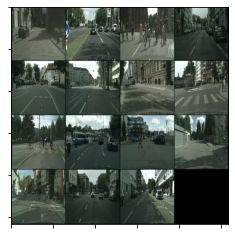

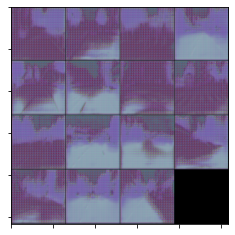

2 / 15 : Generator Loss : 28.756 , Discriminator Loss : 0.000


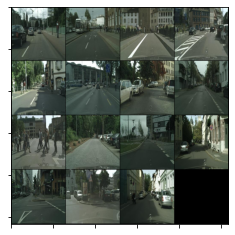

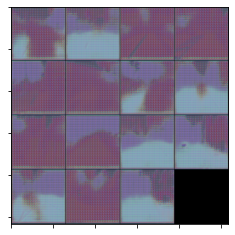

3 / 15 : Generator Loss : 33.518 , Discriminator Loss : 0.000


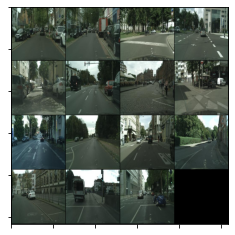

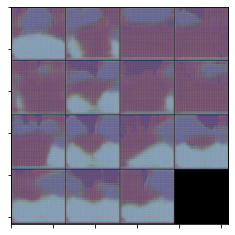

4 / 15 : Generator Loss : 30.992 , Discriminator Loss : 0.000


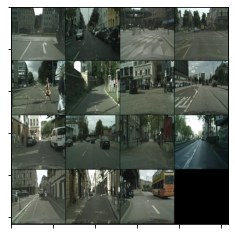

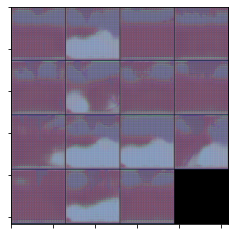

5 / 15 : Generator Loss : 27.193 , Discriminator Loss : 0.000


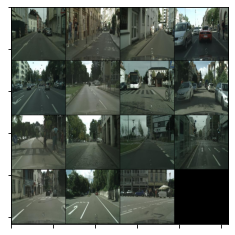

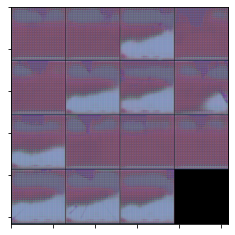

6 / 15 : Generator Loss : 26.371 , Discriminator Loss : 0.000


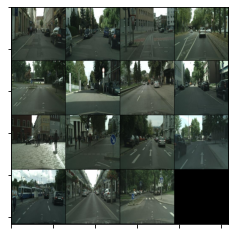

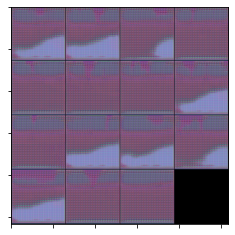

7 / 15 : Generator Loss : 24.239 , Discriminator Loss : 0.000


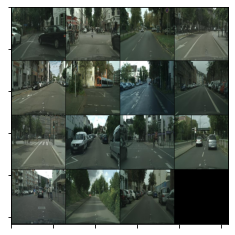

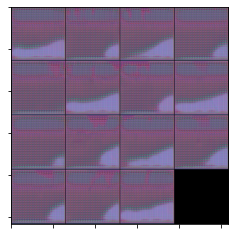

8 / 15 : Generator Loss : 19.877 , Discriminator Loss : 0.000


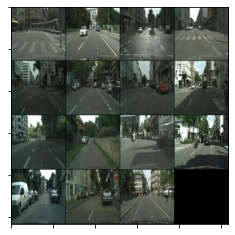

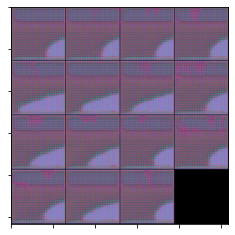

9 / 15 : Generator Loss : 17.036 , Discriminator Loss : 0.000


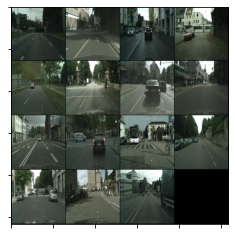

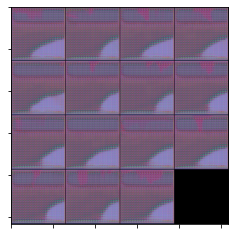

10 / 15 : Generator Loss : 16.819 , Discriminator Loss : 0.000


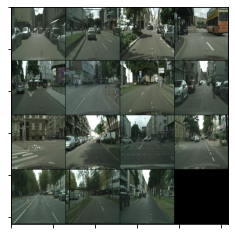

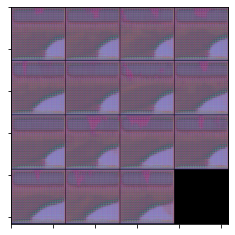

11 / 15 : Generator Loss : 17.147 , Discriminator Loss : 0.000


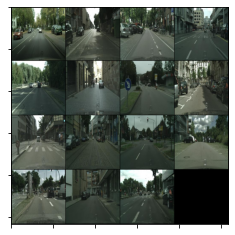

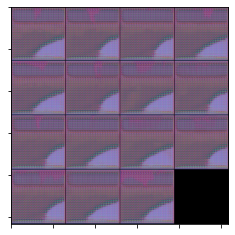

12 / 15 : Generator Loss : 17.474 , Discriminator Loss : 0.000


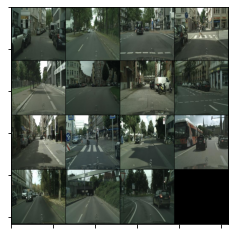

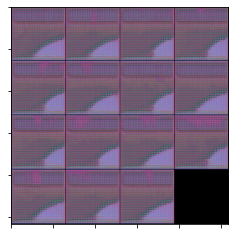

13 / 15 : Generator Loss : 24.775 , Discriminator Loss : 0.000


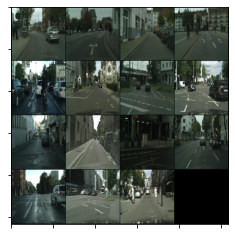

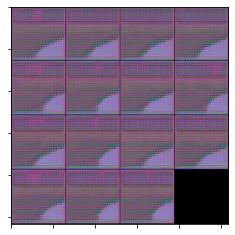

14 / 15 : Generator Loss : 15.133 , Discriminator Loss : 0.000


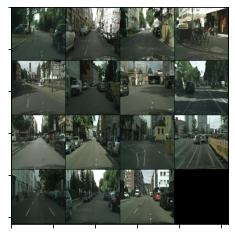

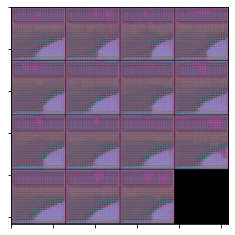

15 / 15 : Generator Loss : 20.028 , Discriminator Loss : 0.000


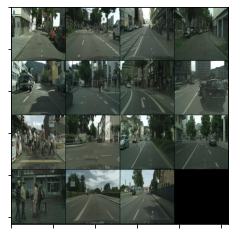

In [20]:
## Training our model ##

total_epochs = 15

for epoch in range(total_epochs):
    
    for inp , target in city_dl:
        
        fake_img = gen(inp).detach()
        
        real_pred = disc(inp , target)
        real_label = torch.ones_like(real_pred)
        
        fake_pred = disc(inp , fake_img)
        fake_label = torch.zeros_like(fake_pred)
        
        real_loss = criterion(real_pred , real_label)
        fake_loss = criterion(fake_pred , fake_label)
        
        total_disc_loss = (real_loss + fake_loss) / 2
        
        disc_optim.zero_grad()
        
        total_disc_loss.backward()
        
        disc_optim.step()
        
        
        gen_img = gen(inp)
        
        gen_pred = disc(gen_img , target)
        gen_original_label = torch.ones_like(gen_pred)
        
        gen_loss = criterion(gen_pred , gen_original_label) + 100 * l1(gen_pred , gen_original_label)
        
        gen_optim.zero_grad()
        
        gen_loss.backward()
        
        gen_optim.step()
        
    print('{} / {} : Generator Loss : {:.3f} , Discriminator Loss : {:.3f}'.format(epoch + 1 , total_epochs , 
          gen_loss.item() , total_disc_loss.item()))
        
    fig , ax = plt.subplots(figsize = (4 , 4))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    plt.imshow(make_grid(denormalize(inp.to('cpu')) , 4).permute(1 , 2 , 0))
    
    fig , ax = plt.subplots(figsize = (4 , 4))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    plt.imshow(make_grid(denormalize(gen_img.detach().to('cpu')) , 4).permute(1 , 2 , 0))
    plt.show()